<a href="https://colab.research.google.com/github/julianrosen/erdos_dl_recanvo_project/blob/main/sj/ALL_AST_%2B_LogReg_Classifying_ReCanvo_Audio_Data_with_AST_and_Logistic_Regression_Using_the_Entire_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Audio Data using AST and Logistic Regression for the Entire Dataset

## Premise of the Project

Our work is building upon the results from a 2021 paper titled “Transfer Learning with Real-World Nonverbal Vocalizations from Minimally Speaking Individuals” [https://www.media.mit.edu/publications/transfer-learning-with-real-world-nonverbal-vocalizations-from-minimally-speaking-individuals/] We use the ReCanVo dataset that the original authors had gathered. Each audio clip is labled by caretakers with tags such as "Happy", Dysregulated" , "Hungry" , etc.

<br>

## Models:
For this specific part, we will use logistic regression as the classifier on features we had previously extracted using AST


<br>


AST [Audio Spectrogram Transformer] is a purely attention based model developed by Yuan Gong, Yu-An Chung, and James Glass for audio classification. [References: https://arxiv.org/pdf/2104.01778, https://github.com/YuanGongND/ast/tree/master] We use the first five layers of their model to extract features.

<br>

## This Notebook


Here, we try using the AST features on the entire draining dataset to check if a classification can be done without seperating participants.

We drop labels that have fewer than 30 data points.






In [1]:
# Update/install packages to make google colab happy.

! pip install -U scikit-learn
! pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 28.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.8 MB/s eta 0:00:00


In [2]:
# Imports #some of these might not be needed

import functools
from pathlib import Path

import torchaudio.transforms as T
import math


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    recall_score,
)
from sklearn.model_selection import (
    cross_val_predict,
    StratifiedKFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#self note: removed the skopt line below so it'll work, if it gives errors
from skopt import BayesSearchCV
import torch
import torchaudio
from tqdm.notebook import tqdm


def to_prob(metric):
    @functools.wraps(metric)
    def metric_that_takes_prob(y_actual, y_pred, sample_weight=None):
        return metric(y_actual, y_pred.argmax(1), sample_weight=sample_weight)

    return metric_that_takes_prob


metrics = {
    "accuracy": to_prob(accuracy_score),
    "balanced_accuracy": to_prob(balanced_accuracy_score),
    "unweighted_f1": to_prob(functools.partial(f1_score, average="macro")),
    "UAR": to_prob(functools.partial(recall_score, average="macro")),
    "logloss": log_loss,
}

## Section 1 : Import the AST Features

In [3]:
#import the AST feature tensors

from google.colab import files
uploaded = files.upload()


Saving X_test_1.pt to X_test_1.pt
Saving y_test.pt to y_test.pt
Saving X_train_1.pt to X_train_1.pt
Saving y_train.pt to y_train.pt


In [4]:
# make feature tensors

import torch

X_train = torch.load('X_train_1.pt')
X_test = torch.load('X_test_1.pt')
y_train = torch.load('y_train.pt')
y_test = torch.load('y_test.pt')

# Check shapes
print(X_train.shape , X_test.shape, y_train.shape, y_test.shape)


torch.Size([4962, 128]) torch.Size([1968, 128]) torch.Size([4962]) torch.Size([1968])


<ipython-input-4-8a710792c8af>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train = torch.load('X_train_1.pt')
<ipython-input-4-8a710792c8af>:6: FutureWarning: You are

## Section 2 : Some Preliminary Things for the Logistic Regression Set-Up

In [5]:
# data files [importing the train test split made by Ale from the link: https://drive.google.com/uc?id=1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4]
! gdown 1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4 -O /content/new_train_test.csv

Downloading...
From: https://drive.google.com/uc?id=1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4
To: /content/new_train_test.csv
100% 523k/523k [00:00<00:00, 85.3MB/s]


In [6]:
#create a dataframe to hold the data
df = pd.read_csv('/content/new_train_test.csv')
#check labels
display(df.Label.value_counts())


,count
Label,
selftalk,1885
frustrated,1536
delighted,1272
dysregulated,704
social,634
request,419
affectionate,129
yes,123
laughter,93


In [7]:
# Dropping lower label counts in the entire dataset
## this cell maybe redundant since we do this specifically for P01 later
Label_counts = df.Label.value_counts()
Label_enough = Label_counts[Label_counts >= 30]

df_dropped = df.loc[df.Label.isin(Label_enough.index)]

display(df_dropped.Label.value_counts())

,count
Label,
selftalk,1885
frustrated,1536
delighted,1272
dysregulated,704
social,634
request,419
affectionate,129
yes,123
laughter,93


In [47]:
#Make the label list for later

Labels = []

# Use a for loop to populate the list
for i in Label_enough.index:
    Labels.append(i)

print(Labels)

['selftalk', 'frustrated', 'delighted', 'dysregulated', 'social', 'request', 'affectionate', 'yes', 'laughter', 'dysregulation-sick', 'happy']


In [8]:
#create dataframes that contain training and testing data seperately

train = df_dropped.loc[df_dropped.is_test == 0]
test = df_dropped.loc[df_dropped.is_test == 1]

display(train.Label.value_counts())

,count
Label,
selftalk,1372
frustrated,1109
delighted,865
dysregulated,522
social,439
request,287
affectionate,103
yes,94
laughter,66


In [9]:
# Some possible sample weights for training and/or metrics.
# session_weight weights each sample based on sessions, so
# that the total weight of observations in each sesion is
# constant. On top of that, session_and_label_weight assigns
# a label to each weight, which is multiplied by the sesion weight,
# in such a way to make the sum of the weights constant by label.
session_weight = (
    (1 / train.Session.value_counts())
    .clip(None, 0.1)
    .loc[train.Session]
).values
session_and_label_weight = (
    1
    / pd.Series(session_weight, train.index)
    .groupby(train.Label)
    .sum()
).loc[train.Label].values * session_weight

## Section 3: Logistic Regression for Feature X

X = output of the initial AST layer (which was a 2dim tensor of size 1024 x 128 whose entries were averaged over the dimension with the longer length, which gives us 128 features for each datapoint.)


In [10]:
# checking accuracy for feature set 1 : X_1
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X_train.reshape(len(X_train), -1),
    y_train,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.9996343558999884)])
Best accuracy: 0.5245931232556631


In [11]:
#save the best param
P = opt.best_params_

In [12]:
print(P)

OrderedDict([('logisticregression__C', 0.9996343558999884)])


In [15]:
y = y_train

In [59]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X_train.reshape(len(X_train), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    #params={"logisticregression__sample_weight": session_weight}, ##just checking
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.525
balanced_accuracy,0.437
unweighted_f1,0.438
UAR,0.437
logloss,1.357


,session_weight
accuracy,0.446
balanced_accuracy,0.409
unweighted_f1,0.393
UAR,0.409
logloss,1.550


,session_and_label_weight
accuracy,0.409
balanced_accuracy,0.409
unweighted_f1,0.411
UAR,0.409
logloss,1.838


In [60]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=Labels, index=Labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,selftalk,frustrated,delighted,dysregulated,social,request,affectionate,yes,laughter,dysregulation-sick,happy
actual_label,,,,,,,,,,,
selftalk,37,4,1,1,9,0,7,0,0,0,0
frustrated,4,710,41,26,247,9,59,2,5,0,6
delighted,2,55,336,9,78,8,23,0,3,8,0
dysregulated,2,27,8,174,153,2,47,1,23,0,2
social,13,175,60,47,897,20,144,1,6,4,5
request,1,35,19,15,89,23,88,1,1,0,15
affectionate,4,86,37,37,307,29,323,0,9,7,26
yes,0,6,3,12,35,0,4,1,5,0,0
laughter,0,4,0,22,16,0,7,0,54,0,0


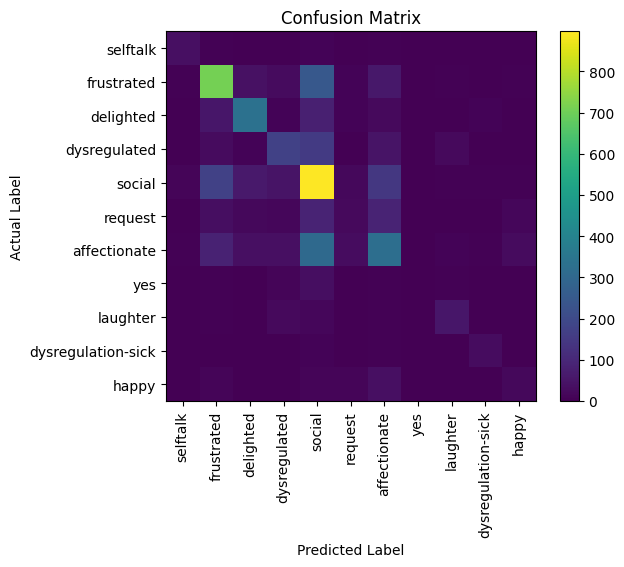

In [61]:
# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.xticks(range(len(Labels)), labels=Labels, rotation='vertical')
plt.yticks(range(len(Labels)), labels=Labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

# Show the plot
plt.show()

We can see that the performance here is much worse in comparison to the medel performance for the two individual participants (which is to be expected).

## Section 4 : Predictions on the Test Set

In [20]:
model = est

In [29]:
#getting the model and the parameter
model = LogisticRegression(C=0.9996343558999884)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.9996343558999884)

In [58]:
# Predict the probabilities for the test set
probabilities = model.predict_proba(X_test)

# Predict the class labels for the test set
predictions = model.predict(X_test) ## Should X_test should be replaced with X_test.reshape(len(X_test), -1) ?

#metrics

#checking accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

# Compute the balanced accuracy score
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print(f'Balanced Accuracy Score: {balanced_accuracy}')

#f1 score
f1 = f1_score(y_test, predictions, average='macro')
print(f'F1 Score: {f1}')


Accuracy: 0.4247967479674797
Balanced Accuracy Score: 0.33265907312729104
F1 Score: 0.35173611334269667


In [50]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y_test, predictions), columns=Labels, index=Labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,selftalk,frustrated,delighted,dysregulated,social,request,affectionate,yes,laughter,dysregulation-sick,happy
actual_label,,,,,,,,,,,
selftalk,8,1,1,0,5,0,0,0,0,0,0
frustrated,0,242,8,15,120,1,38,0,0,0,3
delighted,0,28,88,3,46,1,14,0,1,1,0
dysregulated,0,26,12,39,75,0,42,0,1,0,0
social,1,70,19,18,330,3,69,0,1,1,1
request,0,21,21,7,44,5,29,0,0,0,5
affectionate,1,56,25,15,184,3,105,0,0,3,15
yes,0,9,0,8,9,0,1,0,0,0,0
laughter,0,0,0,7,10,1,2,0,6,0,0


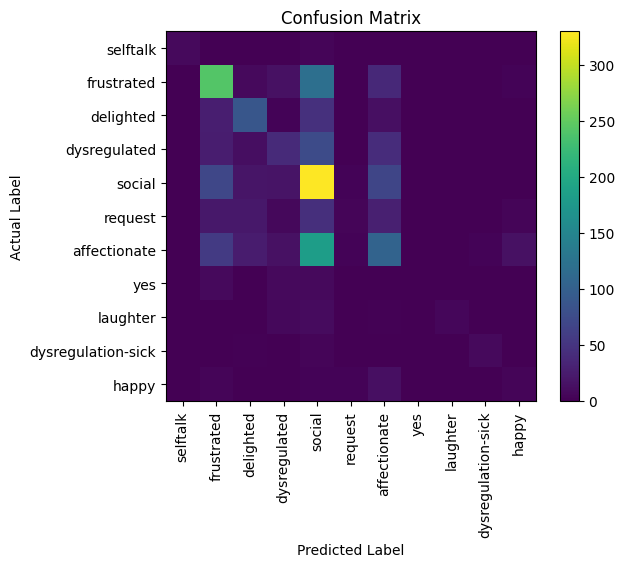

In [53]:
# Create a heatmap
plt.imshow(cm, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.xticks(range(len(Labels)), labels=Labels, rotation='vertical')
plt.yticks(range(len(Labels)), labels=Labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

# Show the plot
plt.show()